## 楢崎さんの卒研 (2022)

ターゲット：乳房超音波画像データセット (Breast Ultrasound Images Dataset)   
https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset 

正常画像(normal)，良性画像(benign)，および悪性画像(malignant)の3クラス分類問題

それぞれの画像数は以下のとおり：
- benign（437 images / mask: 437 images） 
- malignant（210 images / mask: 210 images） 
- normal（133 images / mask: 133 images） 

本ノートブックの目的：基礎となるコードを示す。


In [1]:
# 画像ファイルのパスの収集 ／ クラス番号の設定
parent_dir = 'Dataset_BUSI_with_GT'

import glob

# クラス名：以下のコードにより 'benign' は 0, 'malignant' は 1, 'normal' は 2 が振られる
class_names = ['benign', 'malignant', 'normal']

# データ読み込み
X = [] # 画像ファイルのパス名
y = [] # クラス番号
for class_name in class_names:
    paths = glob.glob("{0}/{1}/{1}*).png".format(parent_dir, class_name))
    X += paths
    y += [class_names.index(class_name)]*len(paths)

In [2]:
# 一応，サイズを確認 → 画像数が冒頭の値と一致しない
print(len(X))
print(len(y))

In [3]:
import collections
collections.Counter(y)

In [4]:
# 試しに１枚を表示してみる
from PIL import Image

im = Image.open(X[0])
print(im.format, im.size, im.mode)
im.show()

PNG (462, 391) RGB


In [5]:
# データセットの中身をチェック
#
# 全ての画像の
# ・モード (RGB / Grayscale) をチェック → 全て RGB である
# ・フォーマットをチェック → 全て PNG である
# ・サイズをチェック → 画像サイズはバラバラ
from PIL import Image

modes = []
formats = []
sizes = []
for path in X:
    im = Image.open(path)
    modes.append(im.mode)
    formats.append(im.format)
    sizes.append(im.size)
    im.close()
    
print(set(modes))
print(set(formats))
print(set(sizes))

{'RGB'}
{'PNG'}
{(761, 619), (563, 473), (880, 567), (573, 428), (591, 464), (1048, 578), (564, 474), (640, 594), (608, 660), (544, 468), (683, 574), (552, 490), (556, 488), (600, 396), (711, 492), (500, 327), (770, 578), (679, 567), (526, 474), (567, 475), (620, 490), (420, 474), (678, 571), (770, 425), (602, 469), (560, 463), (503, 328), (706, 526), (563, 468), (769, 582), (564, 469), (576, 434), (370, 338), (556, 465), (552, 467), (781, 574), (766, 585), (556, 474), (613, 581), (611, 382), (592, 387), (555, 487), (603, 396), (699, 531), (567, 470), (544, 328), (467, 392), (449, 594), (768, 487), (693, 582), (761, 600), (560, 467), (563, 463), (560, 476), (761, 618), (785, 585), (757, 575), (389, 594), (552, 462), (685, 583), (552, 471), (766, 580), (556, 469), (747, 576), (781, 578), (463, 390), (750, 572), (555, 491), (783, 587), (886, 581), (567, 465), (558, 496), (467, 387), (449, 598), (560, 462), (785, 571), (560, 471), (575, 432), (777, 576), (510, 470), (772, 479), (438, 463)

In [6]:
# 学習データ／テストデータに分割
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

/home/muto/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [7]:
# Dataset クラスの定義

import numpy as np
from PIL import Image
from pathlib import Path
import torch
# import torch.utils.data as data
from torchvision import transforms

# Transformer の定義
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # transforms.Grayscale(num_output_channels=3), # ResNet 等に喰わせるため，あえて３チャネル
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset : データソースから1個ずつデータを取り出すクラス
# 実装が必要なメソッドは__getitem__と__len__の2つ
# https://ohke.hateblo.jp/entry/2019/12/28/230000

# (メモ) このデータセットで transform=None はあり得ない！！
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None): #, input_size):
        super().__init__()
        
        self.transform = transform
        self.image_paths = image_paths
        self.labels = labels
        self.len = len(self.image_paths)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        
        # 入力
        image = Image.open(image_path)
        '''
        if self.transform:
            image = self.transform(image_array)
        else:
            image = torch.Tensor(np.transpose(image_array, (2, 0, 1)))/255  # for 0~1 scaling
        '''
        if self.transform:
            image = self.transform(image)
        else:
            image = np.asarray(image)
            image = torch.from_numpy(image)
                
        return image, label

train_dataset = MyDataset(X_train, y_train, transform=transform) #, (224, 224))
test_dataset = MyDataset(X_test, y_test, transform=transform) #, (224, 224))

# 動作チェック
image, label = train_dataset[0]
print(image.size(), label)  # torch.Size([3, 256, 256]) 1
print(type(image))
print(type(label))

torch.Size([3, 224, 224]) 1
<class 'torch.Tensor'>
<class 'int'>


In [8]:
# DataLoader の定義

BATCH_SIZE = 16

trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=4, drop_last=True
)

testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=4, drop_last=True
)

# 動作チェック
images, labels = next(iter(trainloader))
print(images.size())  # torch.Size([16, 3, 256, 256])
print(labels.size())  # torch.Size([16])

torch.Size([16, 3, 224, 224])
torch.Size([16])


In [9]:
# モデル / optimizer / criterion の定義

import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models

# GPUあれば使う
def check_cuda():
    return 'cuda:0' if torch.cuda.is_available() else 'cpu'

device = torch.device(check_cuda()) # "cuda:0"

import sys
print("device: {}".format(device), file=sys.stderr)

# net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True) #ResNet
# net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet101', pretrained=True) #ResNet

# ResNet18
net = models.resnet18(pretrained=True)
num_features = net.fc.in_features
net.fc = torch.nn.Linear(num_features, len(class_names))

# ResNet50
'''
net = models.resnet50(pretrained=True)
num_features = net.fc.in_features
net.fc = torch.nn.Linear(num_features, 3) # 3 : number of class (normal, pneumonia, COVID-19)
'''

# VGG16
'''
net = models.vgg16(pretrained=True)
num_features = net.classifier[6].in_features # in_features = 4096
net.classifier[6] = torch.nn.Linear(num_features, 3) # 3 : number of class (normal, pneumonia, COVID-19)
'''

# VGG19
'''
net = models.vgg19(pretrained=True)
num_features = net.classifier[6].in_features # in_features = 4096
net.classifier[6] = torch.nn.Linear(num_features, 3) # 3 : number of class (normal, pneumonia, COVID-19)
'''

# Inception v3
# aux_logits の扱いについて：
# https://discuss.pytorch.org/t/error-in-training-inception-v3/23933/7
'''
num_classes = 3 # 3 : number of class (normal, pneumonia, COVID-19)
net = models.inception_v3(pretrained=True, aux_logits=False)
#num_ftrs = net.AuxLogits.fc.in_features
#net.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
num_features = net.fc.in_features # in_features = 2048
net.fc = torch.nn.Linear(num_features, num_classes)
'''

# SqueezeNet 1.1
'''
num_classes = 3 # 3 : number of class
net = models.squeezenet1_1(pretrained=True)
net.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
net.num_classes = num_classes
'''

net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.005)

print(net)

device: cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
# 学習
# https://qiita.com/mathlive/items/8e1f9a8467fff8dfd03c

EPOCH = 50

train_loss_value=[]      #trainingのlossを保持するlist
train_acc_value=[]       #trainingのaccuracyを保持するlist
test_loss_value=[]       #tes%MCEPASTEBIN%tのlossを保持するlist
test_acc_value=[]        #testのaccuracyを保持するlist 

for epoch in range(EPOCH):
    print('epoch', epoch+1)    #epoch数の出力

    # 学習
    net.train() # 学習モード
    for (inputs, labels) in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    #train dataを使ってテストをする(パラメータ更新がないようになっている)
    sum_loss = 0.0          #lossの合計
    sum_correct = 0         #正解率の合計
    sum_total = 0           #dataの数の合計

    net.eval() # 評価モード
    for (inputs, labels) in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        sum_loss += loss.item()                            #lossを足していく
        _, predicted = outputs.max(1)                      #出力の最大値の添字(予想位置)を取得
        sum_total += labels.size(0)                        #labelの数を足していくことでデータの総和を取る
        sum_correct += (predicted == labels).sum().item()  #予想位置と実際の正解を比べ,正解している数だけ足す
    print("train mean loss={}, accuracy={}"
            .format(sum_loss*BATCH_SIZE/len(trainloader.dataset), float(sum_correct/sum_total)))  #lossとaccuracy出力
    train_loss_value.append(sum_loss*BATCH_SIZE/len(trainloader.dataset))  #traindataのlossをグラフ描画のためにlistに保持
    train_acc_value.append(float(sum_correct/sum_total))   #traindataのaccuracyをグラフ描画のためにlistに保持

    '''
    with open("/home/muto/Dropbox/20201230.txt", 'a') as fp:
        print('epoch{}'.format(epoch+1), file=fp)
        print("train  mean loss={}, accuracy={}"
              .format(sum_loss*BATCH_SIZE/len(trainloader.dataset), float(sum_correct/sum_total)), file=fp)
    '''
        
    #test dataを使ってテストをする
    sum_loss = 0.0
    sum_correct = 0
    sum_total = 0

    cm_predicted_list = [] # confusion matrix で利用するため予測値を蓄える
    cm_true_list = [] # confusion matrix で利用するため真値を蓄える
    
    net.eval() # 評価モード
    for (inputs, labels) in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        sum_loss += loss.item()
        _, predicted = outputs.max(1)
        sum_total += labels.size(0)
        sum_correct += (predicted == labels).sum().item()
        
        # confusion matrix のため予測値／真値を蓄える
        cm_predicted_list += predicted.tolist()
        cm_true_list += labels.tolist()
    print("test  mean loss={}, accuracy={}"
            .format(sum_loss*BATCH_SIZE/len(testloader.dataset), float(sum_correct/sum_total)))
    test_loss_value.append(sum_loss*BATCH_SIZE/len(testloader.dataset))
    test_acc_value.append(float(sum_correct/sum_total))

    '''
    with open("/home/muto/Dropbox/20201230.txt", 'a') as fp:
        print("test  mean loss={}, accuracy={}"
              .format(sum_loss*BATCH_SIZE/len(testloader.dataset), float(sum_correct/sum_total)), file=fp)
    '''
    

epoch 1
train mean loss=0.938888783856626, accuracy=0.5533088235294118
test  mean loss=0.9068557584387624, accuracy=0.5535714285714286
epoch 2
train mean loss=0.7917497690780696, accuracy=0.6286764705882353
test  mean loss=0.8135166290478829, accuracy=0.5982142857142857
epoch 3
train mean loss=0.6964217498625591, accuracy=0.71875
test  mean loss=0.7537067038381201, accuracy=0.6696428571428571
epoch 4
train mean loss=0.6476846841665415, accuracy=0.7702205882352942
test  mean loss=0.7132675668113252, accuracy=0.6785714285714286
epoch 5
train mean loss=0.5804452503120506, accuracy=0.7977941176470589
test  mean loss=0.6739453332036989, accuracy=0.7098214285714286
epoch 6
train mean loss=0.5202171400789812, accuracy=0.8345588235294118
test  mean loss=0.6476418788616474, accuracy=0.7008928571428571
epoch 7
train mean loss=0.4645895198151305, accuracy=0.8860294117647058
test  mean loss=0.6193548063946586, accuracy=0.7410714285714286
epoch 8
train mean loss=0.422028824086591, accuracy=0.900735

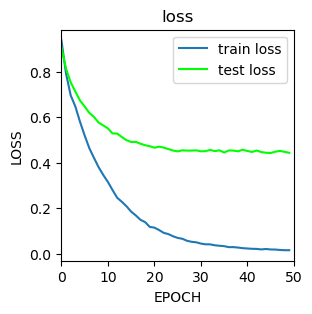

In [11]:
# 損失の可視化
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))

plt.plot(range(EPOCH), train_loss_value)
plt.plot(range(EPOCH), test_loss_value, c='#00ff00')
plt.xlim(0, EPOCH)
# plt.ylim(0, 2.5)
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.legend(['train loss', 'test loss'])
plt.title('loss')
plt.savefig("loss_image.png")

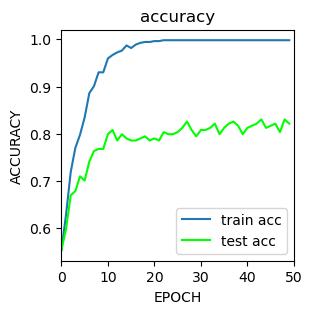

In [14]:
# 正解率の可視化
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))

plt.plot(range(EPOCH), train_acc_value)
plt.plot(range(EPOCH), test_acc_value, c='#00ff00')
plt.xlim(0, EPOCH)
# plt.ylim(0, 1)
plt.xlabel('EPOCH')
plt.ylabel('ACCURACY')
plt.legend(['train acc', 'test acc'])
plt.title('accuracy')
plt.savefig("accuracy_image.png")

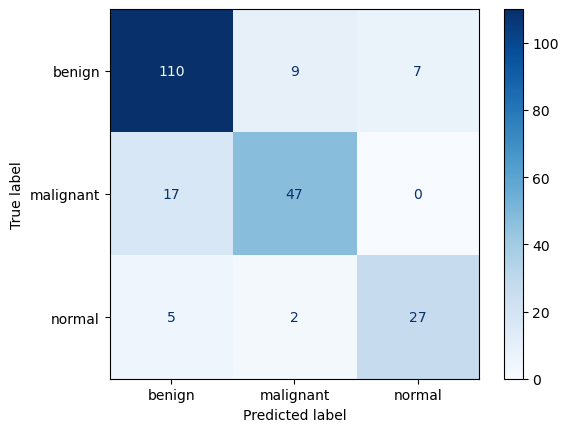

In [15]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(cm_true_list, cm_predicted_list)
cmp = ConfusionMatrixDisplay(cm, display_labels=class_names)

cmp.plot(cmap=plt.cm.Blues)